In [156]:
import sklearn as sk
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

PERIOD = 10

In [26]:
#  Data set taken from http://www.cryptodatadownload.com/index.html
class DatasetBTC(torch.utils.data.Dataset):
    def __init__(self, csv_file, period=PERIOD):
        self.period = period
        
        # load dataset
        df = pd.read_csv(csv_file)
        dataset = df[['Date','Close']]
        dataset.columns = ['Date', 'Price']
        dataset = dataset.iloc[::-1]
        
        # scale datas
        self.scaler = StandardScaler()
        dataset[['Price']] = self.scaler.fit_transform(dataset[['Price']])
        
        self.length = len(dataset[[]])
        
        # compute dataset
        self.dataset = self.build_dataset(dataset)
        
    def get_sample(self, dataset, i):
        n = len(dataset)
        min_nb = 24*35
        if i < min_nb:
            return None
        if i >= n-self.period:
            return None
        datas = []
        for k in range(24):
            datas.append(dataset.iloc[i-k]['Price'])
        for k in range(7):
            datas.append(dataset.iloc[i-24*(k+1)]['Price'])
        for k in range(4):
            datas.append(dataset.iloc[i-(24*7)*(k+2)]['Price'])
        datas.reverse()
        return datas,dataset.iloc[i+self.period]['Price']

    def build_dataset(self, dataset):
        inputs = []
        labels = []
        for k in tqdm(range(self.length)):
            sample = self.get_sample(dataset,k)
            if sample is not None:
                inputs.append(sample[0])
                labels.append(sample[1])
        return np.array(inputs, dtype=np.double), np.array(labels, dtype=np.double).reshape(-1,1)
    
    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, idx):
        return self.dataset[0][idx],self.dataset[1][idx]

In [27]:
def get_sample(prices, i, period=PERIOD):
    n = len(prices)
    min_nb = 24*35
    if i < min_nb and i >= n-period:
        return None
    datas = []
    for k in range(24):
        datas.append(prices[i-k])
    for k in range(7):
        datas.append(prices[i-24*(k+1)])
    for k in range(4):
        datas.append(prices[i-(24*7)*(k+2)])
    datas.reverse()
    return datas

In [28]:
dataset = DatasetBTC('BTCUSD_1hr.csv')

100%|██████████| 45657/45657 [02:59<00:00, 254.22it/s]


In [29]:
test_size = int(len(dataset)/10)
train_size = len(dataset) - test_size
print("Dataset size : {}, Trainset size :{}, Testset size:{}".format(len(dataset),train_size,test_size))
train_set, test_set = torch.utils.data.random_split(dataset,[train_size,test_size])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

Dataset size : 44812, Trainset size :40331, Testset size:4481


We now define several models (basic fully connected layers, GRU, LSTM)

# 1 - LSTM

In [30]:
class BTC_LSTM(torch.nn.Module):
    def __init__(self, dim_input=1, hidden_size=128, num_layers=2):
        super(BTC_LSTM,self).__init__()
        self.lstm = torch.nn.LSTM(input_size=dim_input, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        y = torch.unsqueeze(x,-1)
        output,_ = self.lstm(y)
        output = self.fc(self.relu(output[:,-1]))        
        return output

In [31]:
n_epochs = 10
learning_rate = 1e-3
model = BTC_LSTM()
model = model.double()
loss_fn = torch.nn.MSELoss()
criterion = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
train_loss_history = []
test_loss_history = []
eps = 1e-2
lbda = 1e-3
for k in range(n_epochs):
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        pred = model(inputs)
        loss = loss_fn(pred,labels) + lbda*torch.sum(torch.abs(inputs[:,-1]-labels)/(eps+torch.abs(pred-inputs[:,-1])))
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss_history.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in test_dataloader:
            pred = model(inputs)
            l = criterion(pred,labels)
            loss += l
        test_loss_history.append(loss/len(test_set))

100%|██████████| 2521/2521 [01:57<00:00, 21.38it/s]


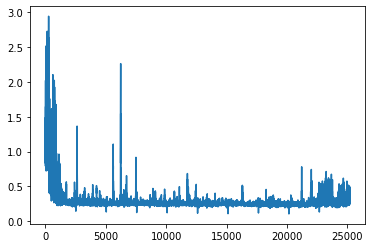

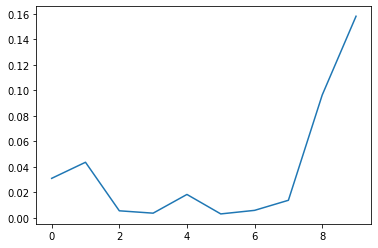

In [33]:
plt.plot(train_loss_history)
plt.show()
plt.plot(test_loss_history)
plt.show()

In [34]:
btc_prices = pd.read_csv('BTCUSD_1hr.csv')
btc_prices = btc_prices[['Date','Close']]
btc_prices.columns = ['Date', 'Price']
btc_prices = btc_prices.iloc[::-1]
prices = btc_prices['Price'].to_list()
dates = btc_prices['Date'].to_list()

In [35]:
predicted_prices = prices[:841]
model.eval()
for k in tqdm(range(840,len(prices)-24)):
    sample = torch.tensor(dataset.get_sample(btc_prices,k)[0])
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1))
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 44793/44793 [06:58<00:00, 107.00it/s]


In [36]:
n = len(predicted_prices)
for k in tqdm(range(20000)):
    sample = torch.tensor(get_sample(predicted_prices,k+n-24))  
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1)) #+ np.random.randn()/100
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 20000/20000 [01:25<00:00, 233.98it/s]


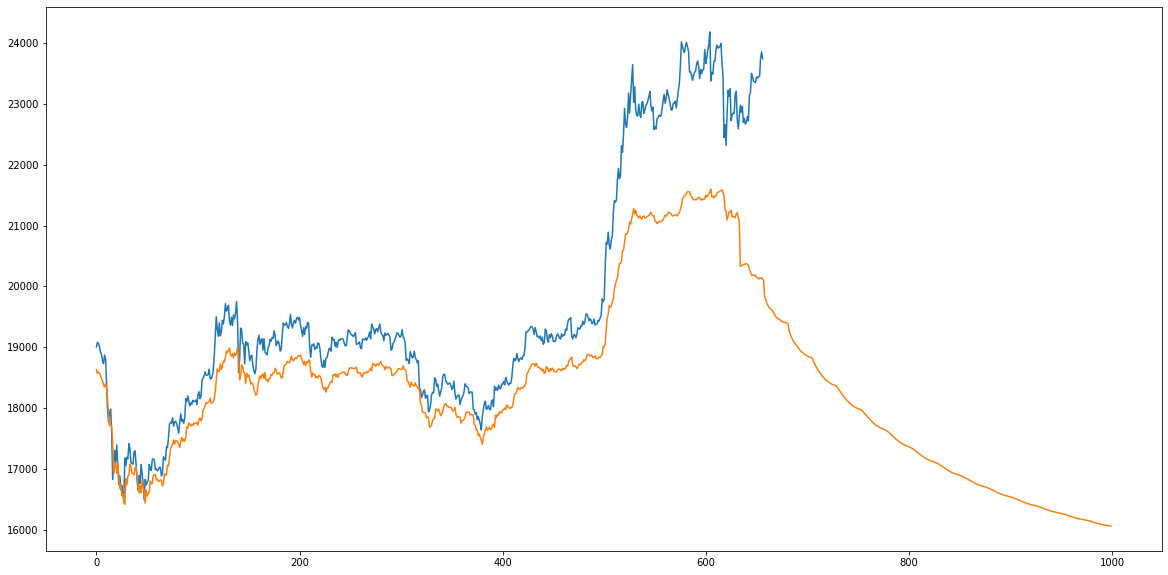

In [37]:
plt.figure(figsize=(20,10))
plt.plot(prices[45000:46000])
plt.plot(predicted_prices[45000:46000])
plt.show()

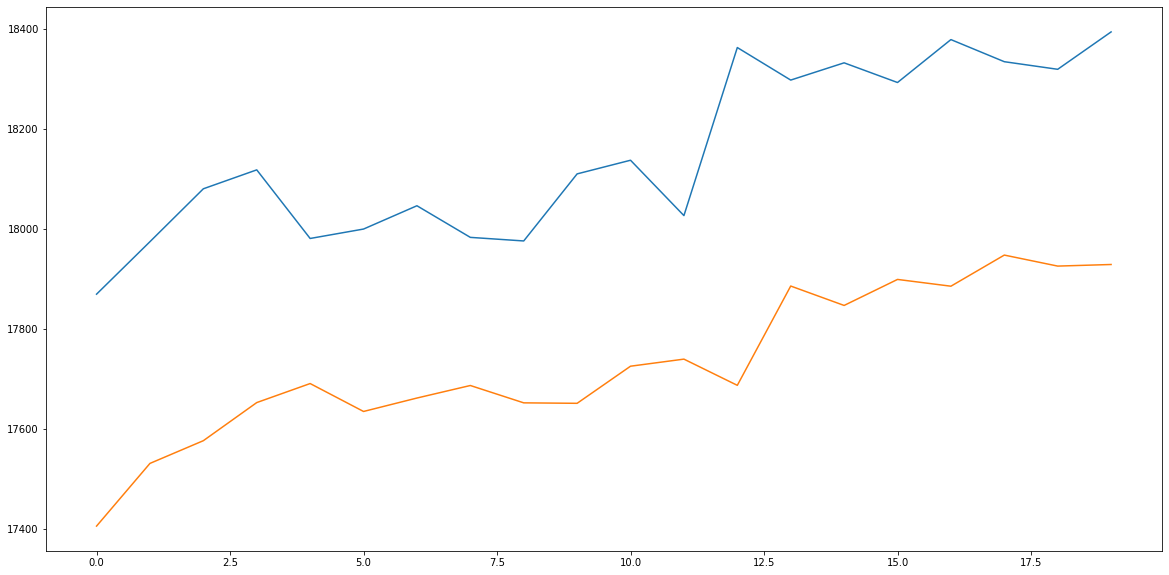

In [38]:
plt.figure(figsize=(20,10))
plt.plot(prices[45380:45400])
plt.plot(predicted_prices[45380:45400])
plt.show()

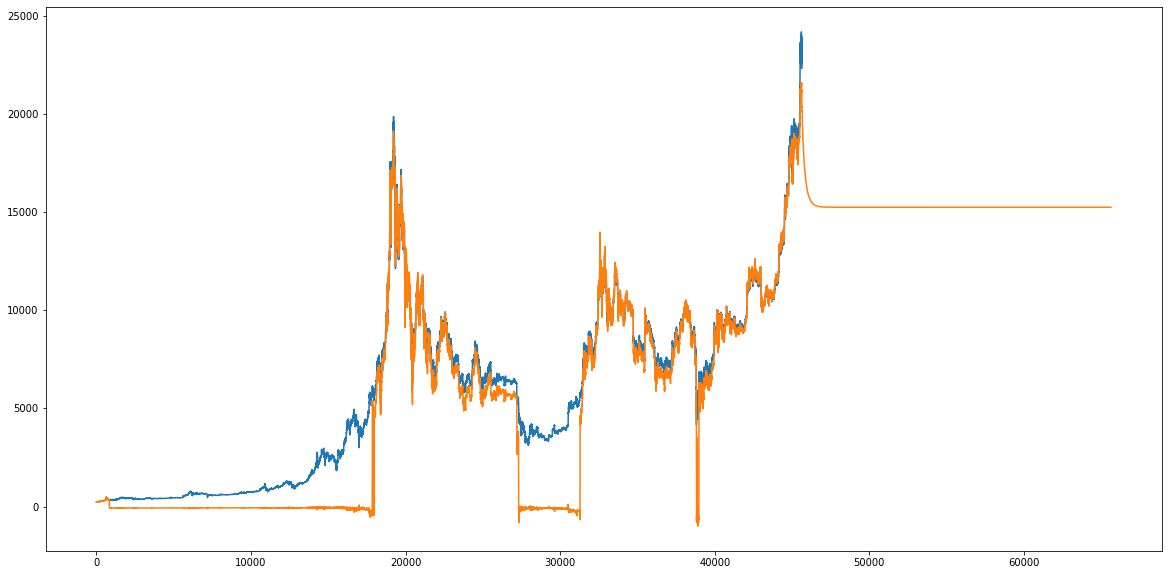

In [39]:
plt.figure(figsize=(20,10))
plt.plot(prices)
plt.plot(predicted_prices)
plt.show()

# 2 - GRU

In [190]:
class BTC_GRU(torch.nn.Module):
    def __init__(self, dim_input=1, hidden_size=128, num_layers=2):
        super(BTC_GRU,self).__init__()
        self.gru = torch.nn.LSTM(input_size=dim_input, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        y = torch.unsqueeze(x,-1)
        output,_ = self.lstm(y)
        output = self.fc(self.relu(output[:,-1]))        
        return output

In [191]:
n_epochs = 10
learning_rate = 1e-2
model = BTC_LSTM()
model = model.double()
loss_fn = torch.nn.MSELoss()
criterion = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [192]:
train_loss_history = []
test_loss_history = []
eps = 1e-2
lbda = 5e-3
for k in tqdm(range(n_epochs)):
    model.train()
    for inputs, labels in train_dataloader:
        pred = model(inputs)
        loss = loss_fn(pred,labels) 
        + lbda*torch.sum(torch.square(torch.sigmoid(torch.abs(inputs[:,-1]-labels)-0.5))
                         /(eps+torch.abs(pred-inputs[:,-1])))
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss_history.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in test_dataloader:
            pred = model(inputs)
            l = criterion(pred,labels)
            loss += l
        test_loss_history.append(loss/len(test_set))

100%|██████████| 10/10 [19:15<00:00, 115.60s/it]


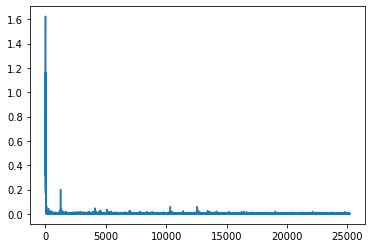

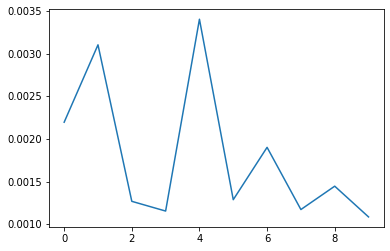

In [193]:
plt.plot(train_loss_history)
plt.show()
plt.plot(test_loss_history)
plt.show()

In [194]:
btc_prices = pd.read_csv('BTCUSD_1hr.csv')
btc_prices = btc_prices[['Date','Close']]
btc_prices.columns = ['Date', 'Price']
btc_prices = btc_prices.iloc[::-1]
prices = btc_prices['Price'].to_list()
dates = btc_prices['Date'].to_list()

In [195]:
predicted_prices = prices[:841]
model.eval()
for k in tqdm(range(840,len(prices)-24)):
    sample = torch.tensor(dataset.get_sample(btc_prices,k)[0])
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1))
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 44793/44793 [07:17<00:00, 102.50it/s]


In [196]:
n = len(predicted_prices)
for k in tqdm(range(20000)):
    sample = torch.tensor(get_sample(predicted_prices,k+n-24))  
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1)) #+ np.random.randn()/100
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 20000/20000 [01:29<00:00, 223.46it/s]


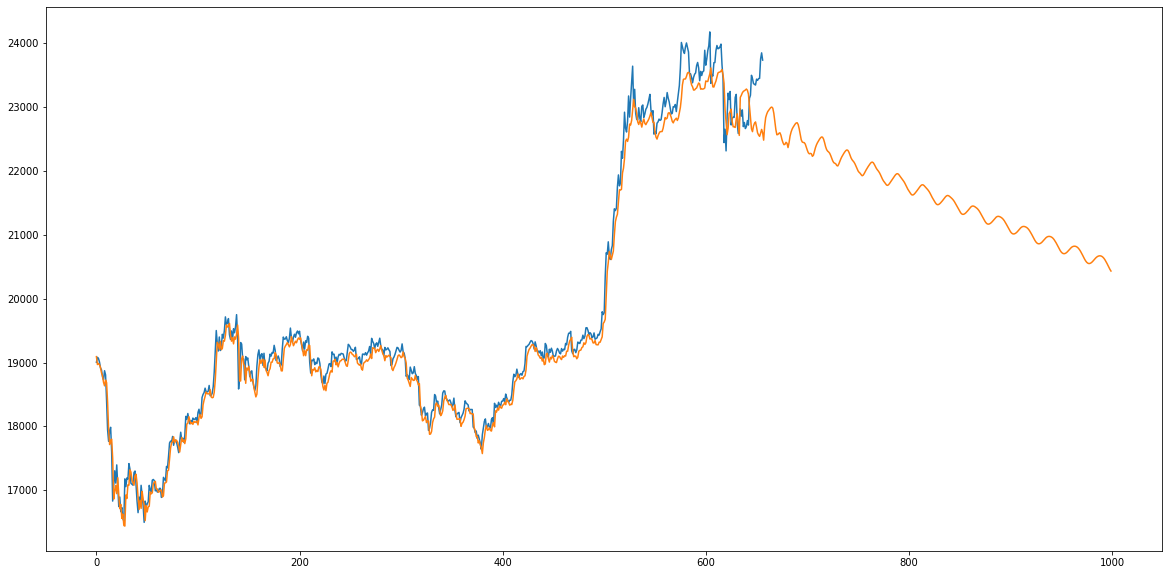

In [197]:
plt.figure(figsize=(20,10))
plt.plot(prices[45000:46000])
plt.plot(predicted_prices[45000:46000])
plt.show()

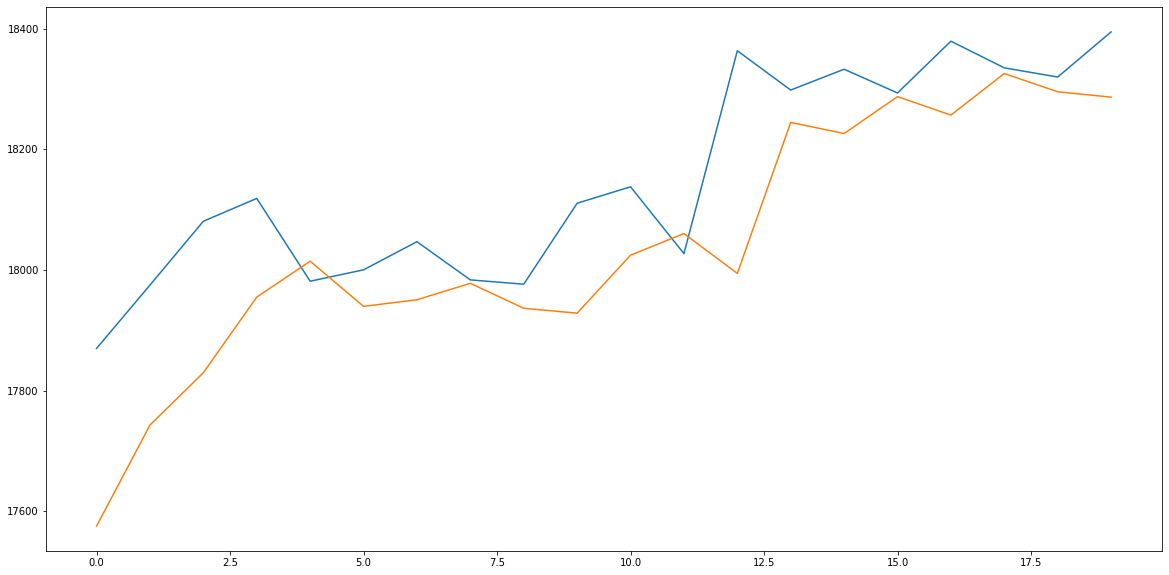

In [198]:
plt.figure(figsize=(20,10))
plt.plot(prices[45380:45400])
plt.plot(predicted_prices[45380:45400])
plt.show()

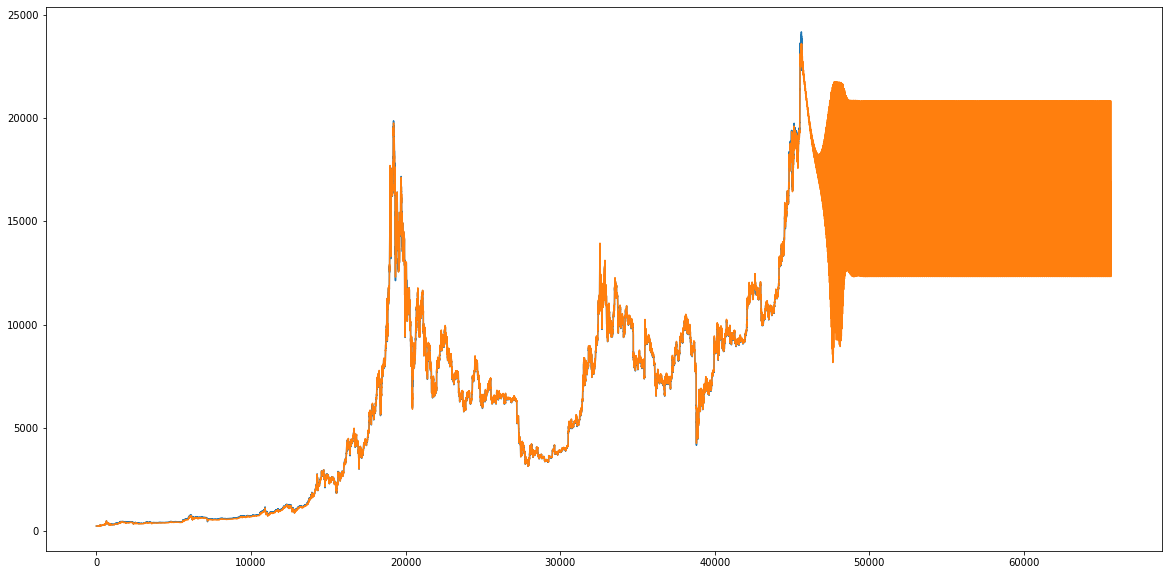

In [199]:
plt.figure(figsize=(20,10))
plt.plot(prices)
plt.plot(predicted_prices)
plt.show()

# 3 - FC

In [80]:
n_epochs = 10
learning_rate = 1e-3
model = torch.nn.Sequential(
    torch.nn.Linear(35,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,1)
)
model = model.double()
loss_fn = torch.nn.MSELoss()
criterion = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [81]:
train_loss_history = []
test_loss_history = []
eps = 1e-2
lbda = 1e-4
for k in range(n_epochs):
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        pred = model(inputs)
        loss = loss_fn(pred,labels) + lbda*torch.sum(torch.abs(inputs[:,-1]-labels)/(eps+torch.abs(pred-inputs[:,-1])))
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss_history.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in test_dataloader:
            pred = model(inputs)
            l = criterion(pred,labels)
            loss += l
        test_loss_history.append(loss/len(test_set))

100%|██████████| 2521/2521 [00:18<00:00, 134.67it/s]


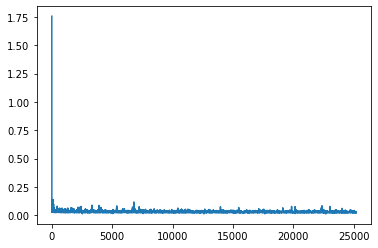

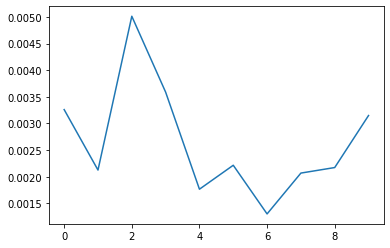

In [82]:
plt.plot(train_loss_history)
plt.show()
plt.plot(test_loss_history)
plt.show()

In [83]:
btc_prices = pd.read_csv('BTCUSD_1hr.csv')
btc_prices = btc_prices[['Date','Close']]
btc_prices.columns = ['Date', 'Price']
btc_prices = btc_prices.iloc[::-1]
prices = btc_prices['Price'].to_list()
dates = btc_prices['Date'].to_list()

In [84]:
predicted_prices = prices[:841]
model.eval()
for k in tqdm(range(840,len(prices)-24)):
    sample = torch.tensor(dataset.get_sample(btc_prices,k)[0])
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1))
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 44793/44793 [04:51<00:00, 153.45it/s]


In [85]:
n = len(predicted_prices)
for k in tqdm(range(20000)):
    sample = torch.tensor(get_sample(predicted_prices,k+n-24))  
    sample = dataset.scaler.transform(sample.unsqueeze(1)).squeeze()
    with torch.no_grad():
        pred = model(torch.tensor(sample).reshape(1,-1)) #+ np.random.randn()/100
        pred = dataset.scaler.inverse_transform(pred).item()
        predicted_prices.append(pred)

100%|██████████| 20000/20000 [00:11<00:00, 1809.36it/s]


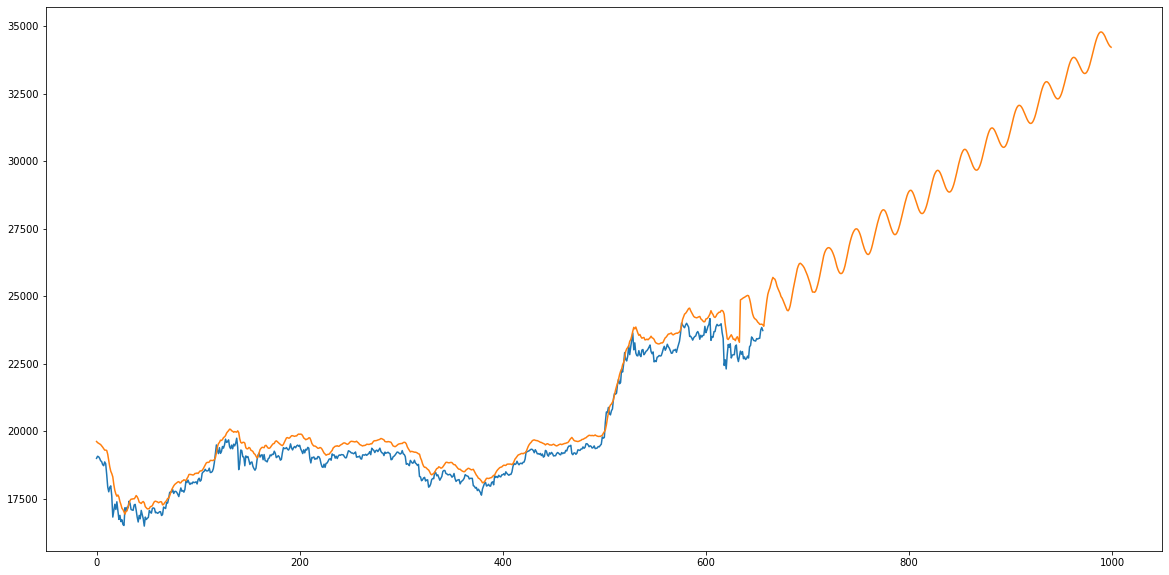

In [86]:
plt.figure(figsize=(20,10))
plt.plot(prices[45000:46000])
plt.plot(predicted_prices[45000:46000])
plt.show()

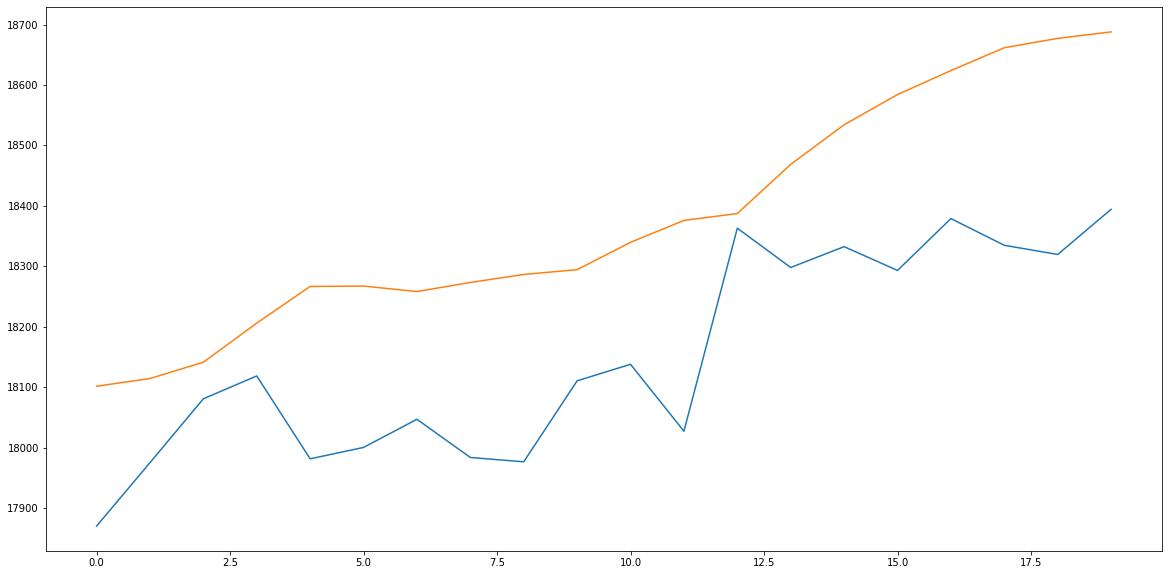

In [87]:
plt.figure(figsize=(20,10))
plt.plot(prices[45380:45400])
plt.plot(predicted_prices[45380:45400])
plt.show()

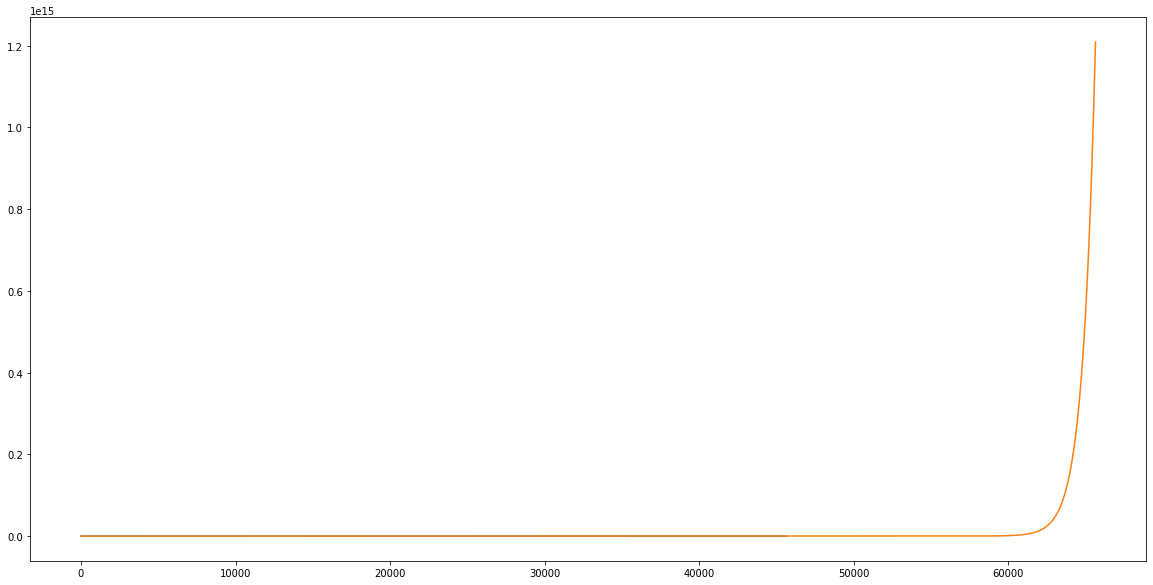

In [88]:
plt.figure(figsize=(20,10))
plt.plot(prices)
plt.plot(predicted_prices)
plt.show()